<a href="https://colab.research.google.com/github/rpasquini/econometria-iae/blob/main/CIA_y_Matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import statsmodels.api as sm
from scipy import stats
import numpy as np
from sklearn.neighbors import KNeighborsRegressor

Extracto de datos de:

[Devoto, F., Duflo, E., Dupas, P., Parienté, W., & Pons, V. (2012). Happiness on tap: piped water adoption in urban Morocco. American Economic Journal: Economic Policy, 4(4), 68-99.](https://web.stanford.edu/~pdupas/MoroccoWaterConnections.pdf)

Las variables fueron modificadas para el proposito de este ejercicio.

Descripción de variables

motivacion: Dummy = 1 si el hogar recibió motivación para conexión \
conectado: Dummy = 1 si el hogar se conectó a la red de agua \
sexojefe:  1 Masculino, 2 Femenino \
edadjefe: Edad Jefe de Hogar \
jefesabeleer: Dummy=1 Jefe sabe leer \
jefesabeescribir: Dummy=1 Jefe sabe escribir \
pdiasfueaescuela: Porcentaje dias hijos fueron a la escuela.

In [5]:
df=pd.read_csv('https://raw.githubusercontent.com/rpasquini/econometrics_and_causality/master/happiness_on_tap_extract.csv')

In [6]:
df

,random_id,motivacion,conectado,sexojefe,edadjefe,jefesabeleer,jefesabeescribir,pdiasfueaescuela
0,1,0,0,1,37.0,1.0,1.0,NaN
1,3,1,1,1,45.0,0.0,0.0,57.142860
2,5,0,0,1,50.0,1.0,1.0,85.714287
3,7,1,1,1,54.0,1.0,1.0,85.714287
4,8,0,0,2,66.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...
783,1030,1,1,1,30.0,1.0,1.0,NaN
784,1031,1,1,1,37.0,1.0,1.0,14.285715
785,1033,0,0,1,52.0,1.0,1.0,NaN
786,1034,0,0,2,66.0,0.0,0.0,NaN


In [7]:
df['dsexojefe']=np.where(df['sexojefe']==1,1,0)

In [8]:
df=df.dropna()

Diferencia entre conectados y no conectados sugiere

In [9]:
df.loc[df.conectado==1].pdiasfueaescuela.mean()-df.loc[df.conectado==0].pdiasfueaescuela.mean()

-3.523604421369363

Antes de continuar verificamos si hay diferencias en las caracteristicas observables


In [10]:
for variable in ['sexojefe','edadjefe','jefesabeleer','jefesabeescribir','pdiasfueaescuela']:
  var_tratados=df[variable].loc[(df.conectado==1) ]
  var_control=df[variable].loc[(df.conectado==0) ]
  print(variable)
  print('dif: ',var_tratados.mean()-var_control.mean())
  resultadottest=stats.ttest_ind(var_tratados, var_control, equal_var=True)
  print('statistic', resultadottest.statistic, 'pvalue', resultadottest.pvalue)


sexojefe
dif:  -0.014426908974972008
statistic -0.3985894717651943 pvalue 0.6904657650625463
edadjefe
dif:  -0.7358919177427055
statistic -0.6786088936491492 pvalue 0.4978839468444204
jefesabeleer
dif:  -0.06260959668420218
statistic -1.2386725523291628 pvalue 0.21638902860325182
jefesabeescribir
dif:  -0.05519687549816665
statistic -1.0737778188107645 pvalue 0.28374413297112716
pdiasfueaescuela
dif:  -3.523604421369363
statistic -1.224783170253449 pvalue 0.22157203698942263


# Recuperando el ATT usando la CIA.
A los fines de un primer ejemplo, vamos a suponer que es suficiente con el control por el sexo del jefe de hogar para eliminar el posible sesgo de selección.
El estimador que propone la teoría es:

$$ATT=E[Y_{1i}∣T_{i}=1]-E[Y_{0i}∣T_{i}=1]=\sum_x\delta_xP(X_i=x|T_i=1)$$

Lo vamos a computar a "mano".

1. Calculamos las diferencias para cada grupo por separado

In [11]:
# Diferencia para jefes hombres
dif_hombres=df.loc[(df.conectado==1)& (df.sexojefe==1)].pdiasfueaescuela.mean() \
-df.loc[(df.conectado==0)&(df.sexojefe==1)].pdiasfueaescuela.mean()
print('dif_hombres ',dif_hombres)
# Diferencia para jefes mujeres

dif_mujeres=df.loc[(df.conectado==1)& (df.sexojefe==2)].pdiasfueaescuela.mean() \
-df.loc[(df.conectado==0)&(df.sexojefe==2)].pdiasfueaescuela.mean()
print('dif_mujeres ',dif_mujeres)


dif_hombres  -3.0902238479861026
dif_mujeres  -6.808688535087725


2. Calculamos la cantidad de hogares tratados en cada grupo considerado

In [12]:
total_hombres=df.loc[(df.sexojefe==1) ].shape[0]
total_mujeres= df.loc[(df.sexojefe==2)].shape[0]
print('total hombres  ', total_hombres, ', total mujeres ', total_mujeres)


total_hombres_tratados=df.loc[(df.sexojefe==1) & (df.conectado==1)].shape[0]
total_mujeres_tratadas= df.loc[(df.sexojefe==2) & (df.conectado==1)].shape[0]
print('total hombres tratados ', total_hombres_tratados, ', total mujeres tratadas ', total_mujeres_tratadas)



total hombres   280 , total mujeres  37
total hombres tratados  146 , total mujeres tratadas  18


3. Calculamos el promedio ponderado usando los hogares tratados

In [13]:
# Average Treatment on the Treated (ATT)
(dif_hombres*total_hombres_tratados+dif_mujeres*total_mujeres_tratadas)/(146+18)

-3.498348020960671

4. Calculamos el estimador del efecto  promedio del tratamiento (ATE) ponderando por la cantidad de hogares en total

In [14]:
# ATE
(dif_hombres*total_hombres+dif_mujeres*total_mujeres)/(280+37)


-3.524240231023201

In [15]:
df.pdiasfueaescuela.mean()

59.801714160883286

# Algoritmo de Matching
Un método alternativo basado en la CIA es asignar a cada hogar tratado un (o un número de) hogar(es) comparables.

Para este procedimiento vamos a utilizar una función de la librería sklearn. Esta función busca, a partir de un conjunto de caracteristicas, la observación más similar.
En particular, el metodo de Kneighbors se utiliza con otro objetivo (para hacer predicciones ) pero aquí es útil para nuestro caso de interes.


In [16]:
# Llamemos X a la lista de variables que vamos a considerar para el matching
X=['dsexojefe', 'edadjefe', 'jefesabeleer', 'jefesabeescribir']


In [27]:
def matching(outcome, treatment, matching_vars, df):

  """
  outcome: nombre de la variable de outcome (string)
  treatment: nombre de la variable de tratamiento (string)
  matching_vars: Vector de nombres de variables a matchear (lista de strings)
  df: dataframe completo

  """

  # Separo las observaciones de conectados y no conectados
  conectados = df.loc[(df[treatment]==1)]
  noconectados = df.loc[(df[treatment]==0)]

  # Entreno el modelo solo en las observaciones correspondientes a los no-conectados.

  modelo = KNeighborsRegressor(n_neighbors=1)

  resultado=modelo.fit(noconectados[matching_vars], noconectados[outcome])

  # una vez que el modelo esta entrenado, le pido una prediccion (i.e., el vecino mas cercano) para los que fueron conectados.

  matchnoconectado=resultado.predict(conectados[matching_vars])

  # Agrego al dataframe de los conectados la información de su match

  df_matcheado=conectados.assign(matchnoconectado=matchnoconectado)

  return df_matcheado




In [28]:
df_matcheado=matching('pdiasfueaescuela','conectado', X, df )
df_matcheado

,random_id,motivacion,conectado,sexojefe,edadjefe,jefesabeleer,jefesabeescribir,pdiasfueaescuela,dsexojefe,probabilidades,matchnoconectado
1,3,1,1,1,45.0,0.0,0.0,57.142860,1,0.605246,14.285715
3,7,1,1,1,54.0,1.0,1.0,85.714287,1,0.484496,85.714287
7,11,0,1,1,52.0,1.0,1.0,71.428574,1,0.489078,71.428574
13,21,1,1,1,51.0,1.0,1.0,71.428574,1,0.491370,85.714287
18,26,1,1,1,45.0,1.0,1.0,57.142860,1,0.505124,71.428574
...,...,...,...,...,...,...,...,...,...,...,...
766,1012,1,1,2,41.0,0.0,0.0,42.857143,0,0.534512,42.857143
768,1014,0,1,1,36.0,1.0,1.0,14.285715,1,0.525734,85.714287
772,1018,1,1,1,51.0,1.0,1.0,85.714287,1,0.491370,85.714287
778,1025,0,1,1,39.0,0.0,0.0,14.285715,1,0.618313,71.428574


In [22]:
np.mean(df_matcheado.pdiasfueaescuela-df_matcheado.matchnoconectado)

-6.707316890243904

# Propensity Score Matching

Mostramos la idea del propensity score utilizando el mismo procedimiento que para el matching, pero en este caso vamos a matchear sobre la probabilidad

In [23]:
def logit(lista, data):
  """
  Funcion que realiza la regresion Logit
  La primera variable de la lista es la dependiente, el resto son las explicativas
  data es la base de datos
  """
  datos=data[lista]
  # el metodo dropna() me permite eliminar las filas que tienen algun valor missing
  datos=datos.dropna()
  Y=datos[lista[0]]
  X=datos[lista[1:]]
  X=sm.add_constant(X)
  modelo=sm.Logit(Y,X)
  modeloajustado=modelo.fit()
  print(modeloajustado.summary())
  return modeloajustado

In [24]:
modelo=logit(['conectado','dsexojefe', 'edadjefe', 'jefesabeleer', 'jefesabeescribir'], data=df)
df['probabilidades']=modelo.predict()

Optimization terminated successfully.
         Current function value: 0.687622
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:              conectado   No. Observations:                  317
Model:                          Logit   Df Residuals:                      312
Method:                           MLE   Df Model:                            4
Date:                Mon, 20 Nov 2023   Pseudo R-squ.:                0.007109
Time:                        14:55:32   Log-Likelihood:                -217.98
converged:                       True   LL-Null:                       -219.54
Covariance Type:            nonrobust   LLR p-value:                    0.5377
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.5142      0.678      0.758      0.448      -0.815       1.843
dsexojefe  

<ipython-input-24-5fba7eb2a84a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['probabilidades']=modelo.predict()


In [25]:
df.head()

,random_id,motivacion,conectado,sexojefe,edadjefe,jefesabeleer,jefesabeescribir,pdiasfueaescuela,dsexojefe,probabilidades
1,3,1,1,1,45.0,0.0,0.0,57.142860,1,0.605246
2,5,0,0,1,50.0,1.0,1.0,85.714287,1,0.493662
3,7,1,1,1,54.0,1.0,1.0,85.714287,1,0.484496
7,11,0,1,1,52.0,1.0,1.0,71.428574,1,0.489078
9,14,0,0,1,42.0,1.0,1.0,42.857143,1,0.511999


<Axes: >

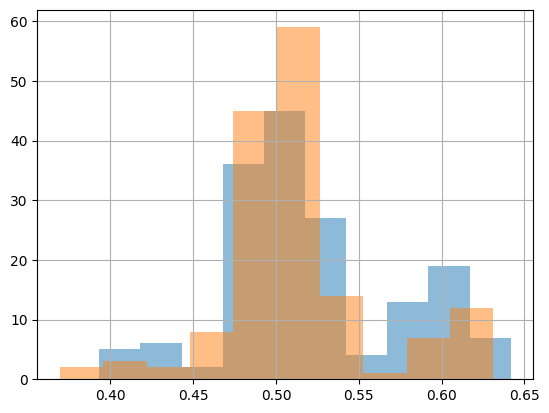

In [29]:
# Vemos que haya un soporte comun en las distribuciones
df.loc[df.conectado==1]['probabilidades'].hist( alpha=0.5)
df.loc[df.conectado==0]['probabilidades'].hist(alpha=0.5)

In [31]:
df_matcheado=matching('pdiasfueaescuela','conectado', ['probabilidades'], df )
df_matcheado

,random_id,motivacion,conectado,sexojefe,edadjefe,jefesabeleer,jefesabeescribir,pdiasfueaescuela,dsexojefe,probabilidades,matchnoconectado
1,3,1,1,1,45.0,0.0,0.0,57.142860,1,0.605246,14.285715
3,7,1,1,1,54.0,1.0,1.0,85.714287,1,0.484496,85.714287
7,11,0,1,1,52.0,1.0,1.0,71.428574,1,0.489078,85.714287
13,21,1,1,1,51.0,1.0,1.0,71.428574,1,0.491370,42.857143
18,26,1,1,1,45.0,1.0,1.0,57.142860,1,0.505124,71.428574
...,...,...,...,...,...,...,...,...,...,...,...
766,1012,1,1,2,41.0,0.0,0.0,42.857143,0,0.534512,71.428574
768,1014,0,1,1,36.0,1.0,1.0,14.285715,1,0.525734,71.428574
772,1018,1,1,1,51.0,1.0,1.0,85.714287,1,0.491370,42.857143
778,1025,0,1,1,39.0,0.0,0.0,14.285715,1,0.618313,71.428574


In [33]:
np.mean(df_matcheado.pdiasfueaescuela-df_matcheado.matchnoconectado)

-4.965156743902439

In [40]:
resultadottest=stats.ttest_ind(df_matcheado.pdiasfueaescuela, df_matcheado.matchnoconectado, equal_var=True)
print('statistic', resultadottest.statistic, 'pvalue', resultadottest.pvalue)

statistic -1.7827298391973592 pvalue 0.07556074409737497


# Utilizando la libreria Causal Inference


https://pypi.org/project/CausalInference/

In [34]:
!pip install causalinference

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 1.4 MB/s eta 0:00:00


In [35]:
from causalinference import CausalModel

In [36]:
X=['dsexojefe', 'edadjefe', 'jefesabeleer', 'jefesabeescribir']

In [39]:
cm = CausalModel( Y=df["pdiasfueaescuela"].values,  D=df["conectado"].values,  X=df[X].values )

cm.est_via_matching(matches=1, bias_adj=True)

print(cm.estimates)
cm.reset()


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -0.716      3.914     -0.183      0.855     -8.388      6.957
           ATC      0.204      4.236      0.048      0.962     -8.099      8.507
           ATT     -1.574      4.226     -0.372      0.710     -9.858      6.709



# Propensity Score using Causal Model

In [38]:
causal = CausalModel(
    Y=df["pdiasfueaescuela"].values,
    D=df["conectado"].values,
    X=df[X].values
)
causal.est_propensity_s()
print(causal.propensity)
causal.stratify_s()
print(causal.strata)



Estimated Parameters of Propensity Score

                    Coef.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
     Intercept      0.294      0.214      1.373      0.170     -0.126      0.714
            X2     -0.312      0.252     -1.238      0.216     -0.806      0.182


Stratification Summary

              Propensity Score         Sample Size     Ave. Propensity   Outcome
   Stratum      Min.      Max.  Controls   Treated  Controls   Treated  Raw-diff
--------------------------------------------------------------------------------
         1     0.496     0.573       153       164     0.515     0.520    -3.524

